In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os
# Please uncomment this when running on Google Colab
# Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [85]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [86]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nasirayub2/human-vital-sign-dataset")

print("Path to dataset files:", path)

Path to dataset files: /content/data/datasets/nasirayub2/human-vital-sign-dataset/versions/1


In [87]:
def prepare_input(df):
    df = df.copy()
    df = df.drop_duplicates()

    columns_to_drop = [
        'Timestamp',
        'Patient ID',
        'Gender',
        'Derived_HRV',
        'Derived_Pulse_Pressure',
        'Derived_BMI',
        'Derived_MAP'
    ]

    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    if 'Risk Category' in df.columns:
        y = df['Risk Category']
        X = df.drop(columns=['Risk Category'])
    else:
        y = None
        X = df

    return X, y


In [88]:
df = pd.read_csv("/content/data/datasets/nasirayub2/human-vital-sign-dataset/versions/1/human_vital_signs_dataset_2024.csv")
df.head()

,Patient ID,Heart Rate,Respiratory Rate,Timestamp,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP,Risk Category
0,1,60,12,2024-07-19 21:53:45.729841,36.861707,95.702046,124,86,37,Female,91.541618,1.679351,0.121033,38,32.459031,98.666667,High Risk
1,2,63,18,2024-07-19 21:52:45.729841,36.511633,96.689413,126,84,77,Male,50.704921,1.992546,0.117062,42,12.771246,98.000000,High Risk
2,3,63,15,2024-07-19 21:51:45.729841,37.052049,98.508265,131,78,68,Female,90.316760,1.770228,0.053200,53,28.821069,95.666667,Low Risk
3,4,99,16,2024-07-19 21:50:45.729841,36.654748,95.011801,118,72,41,Female,96.006188,1.833629,0.064475,46,28.554611,87.333333,High Risk
4,5,69,16,2024-07-19 21:49:45.729841,36.975098,98.623792,138,76,25,Female,56.020006,1.866419,0.118484,62,16.081438,96.666667,High Risk


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Patient ID                200020 non-null  int64  
 1   Heart Rate                200020 non-null  int64  
 2   Respiratory Rate          200020 non-null  int64  
 3   Timestamp                 200020 non-null  object 
 4   Body Temperature          200020 non-null  float64
 5   Oxygen Saturation         200020 non-null  float64
 6   Systolic Blood Pressure   200020 non-null  int64  
 7   Diastolic Blood Pressure  200020 non-null  int64  
 8   Age                       200020 non-null  int64  
 9   Gender                    200020 non-null  object 
 10  Weight (kg)               200020 non-null  float64
 11  Height (m)                200020 non-null  float64
 12  Derived_HRV               200020 non-null  float64
 13  Derived_Pulse_Pressure    200020 non-null  i

In [90]:
df.columns

Index(['Patient ID', 'Heart Rate', 'Respiratory Rate', 'Timestamp',
       'Body Temperature', 'Oxygen Saturation', 'Systolic Blood Pressure',
       'Diastolic Blood Pressure', 'Age', 'Gender', 'Weight (kg)',
       'Height (m)', 'Derived_HRV', 'Derived_Pulse_Pressure', 'Derived_BMI',
       'Derived_MAP', 'Risk Category'],
      dtype='object')

In [91]:
df.value_counts('Risk Category')

,count
Risk Category,
High Risk,105115
Low Risk,94905


<Axes: ylabel='count'>

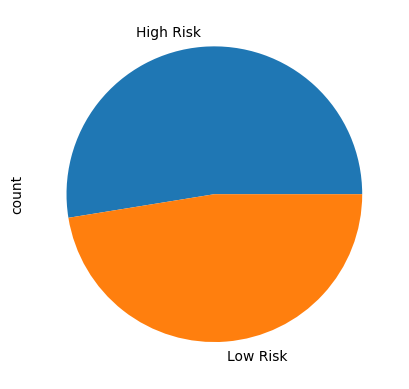

In [92]:
df['Risk Category'].value_counts().plot.pie()

In [93]:
df['Risk Category'].unique()

array(['High Risk', 'Low Risk'], dtype=object)

In [94]:
df = df.drop_duplicates()
df = df.drop(['Timestamp', 'Patient ID', 'Derived_HRV', 'Derived_Pulse_Pressure', 'Derived_BMI', 'Derived_MAP'], axis='columns')
df.head(10)

,Heart Rate,Respiratory Rate,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Risk Category
0,60,12,36.861707,95.702046,124,86,37,Female,91.541618,1.679351,High Risk
1,63,18,36.511633,96.689413,126,84,77,Male,50.704921,1.992546,High Risk
2,63,15,37.052049,98.508265,131,78,68,Female,90.316760,1.770228,Low Risk
3,99,16,36.654748,95.011801,118,72,41,Female,96.006188,1.833629,High Risk
4,69,16,36.975098,98.623792,138,76,25,Female,56.020006,1.866419,High Risk
5,79,12,36.884979,95.987129,130,70,22,Male,79.869933,1.922334,Low Risk
6,81,17,37.273640,99.456716,118,84,43,Male,57.846565,1.831484,High Risk
7,96,15,36.852633,97.124125,135,77,72,Female,71.758972,1.603888,High Risk
8,83,12,36.044191,98.584497,111,84,50,Male,79.295332,1.672735,Low Risk
9,66,15,36.957178,97.916267,131,77,61,Male,53.923400,1.896381,High Risk


In [95]:
X, y = prepare_input(df)


In [96]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [97]:
# Define the DNN model (منسوخ من النوتبوك القديم)
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)  # no sigmoid here


# Initialize model
input_size = X.shape[1]
model = DNN(input_size=input_size)


In [98]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [99]:
# Initialize model weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

DNN(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [100]:
# إعداد مسارات الحفظ بناءً على الوقت
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_path = "/content/drive/MyDrive/Hackathon Models/1. Wearable Sensor Data for Vital Signs Monitoring/"
model_path = f"{base_path}model_vital_{timestamp}.pth"
scaler_path = f"{base_path}scaler_vital_{timestamp}.pkl"
encoder_path = f"{base_path}encoder_vital_{timestamp}.pkl"

# تدريب النموذج
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    # === Training Phase ===
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Accuracy calculation
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = epoch_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)

    # === Evaluation Phase ===
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    val_loss = test_loss / len(test_loader)
    val_acc = correct_test / total_test
    test_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss : {train_loss:.4f} | Train Accuracy : {train_acc*100:.2f} %")
    print(f"  Val   Loss : {val_loss:.4f} | Val   Accuracy : {val_acc*100:.2f} %")
    print("-" * 50)

# 🔍 التوقعات قبل الحفظ
model.eval()
sample_input = next(iter(test_loader))[0][:5]
with torch.no_grad():
    logits = model(sample_input).squeeze()
    probs_before = torch.sigmoid(logits).numpy()
print("\n🔎 Predictions BEFORE saving:", probs_before)

# ✅ حفظ النموذج والمكونات
torch.save(model.state_dict(), model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(label_encoder, encoder_path)

print(f"\n✅ Saved to Drive:")
print(f"- Model   : {model_path}")
print(f"- Scaler  : {scaler_path}")
print(f"- Encoder : {encoder_path}")

# 🔁 التحقق من التوقعات بعد التحميل
model_loaded = DNN(input_size=X.shape[1])
model_loaded.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model_loaded.eval()

with torch.no_grad():
    logits_loaded = model_loaded(sample_input).squeeze()
    probs_after = torch.sigmoid(logits_loaded).numpy()

print("\n🔁 Predictions AFTER loading:", probs_after)


Epoch [1/10]
  Train Loss : 0.0761 | Train Accuracy : 96.80 %
  Val   Loss : 0.0267 | Val   Accuracy : 99.09 %
--------------------------------------------------
Epoch [2/10]
  Train Loss : 0.0301 | Train Accuracy : 98.79 %
  Val   Loss : 0.0362 | Val   Accuracy : 98.55 %
--------------------------------------------------
Epoch [3/10]
  Train Loss : 0.0247 | Train Accuracy : 98.96 %
  Val   Loss : 0.0243 | Val   Accuracy : 98.99 %
--------------------------------------------------
Epoch [4/10]
  Train Loss : 0.0217 | Train Accuracy : 99.09 %
  Val   Loss : 0.0200 | Val   Accuracy : 99.16 %
--------------------------------------------------
Epoch [5/10]
  Train Loss : 0.0200 | Train Accuracy : 99.15 %
  Val   Loss : 0.0227 | Val   Accuracy : 99.06 %
--------------------------------------------------
Epoch [6/10]
  Train Loss : 0.0191 | Train Accuracy : 99.21 %
  Val   Loss : 0.0174 | Val   Accuracy : 99.26 %
--------------------------------------------------
Epoch [7/10]
  Train Loss : 

In [116]:
import torch
import joblib

# === 1. Define model structure (نفس اللي درّبته) ===
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)  # لا تستخدم sigmoid هنا

# === 2. Define paths to last saved model ===
timestamp = "20250327_032916"  # <-- غيّرها لو استخدمت نسخة جديدة
base_path = "/content/drive/MyDrive/Hackathon Models/1. Wearable Sensor Data for Vital Signs Monitoring/"
model_path   = f"{base_path}model_vital_{timestamp}.pth"
scaler_path  = f"{base_path}scaler_vital_{timestamp}.pkl"
encoder_path = f"{base_path}encoder_vital_{timestamp}.pkl"

# === 3. Load model, scaler, encoder ===
input_size = X.shape[1]  # من نفس الداتا اللي استخدمتها
model = DNN(input_size=input_size)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

scaler = joblib.load(scaler_path)
label_encoder = joblib.load(encoder_path)

# === 4. Prepare the data again (نفس خطوات التدريب) ===
df = pd.read_csv(csv_path)
X_raw, y_raw = prepare_input(df)

X_scaled = scaler.transform(X_raw)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# === 5. Get predictions on 10 random rows from original data ===
import numpy as np

random_indices = np.random.choice(len(X_tensor), size=10, replace=False)
samples = X_tensor[random_indices]
true_labels = label_encoder.transform(y_raw)[random_indices]

with torch.no_grad():
    logits = model(samples).squeeze()
    probs = torch.sigmoid(logits).numpy()
    predictions = (probs >= 0.5).astype(int)
    decoded_preds = label_encoder.inverse_transform(predictions)
    decoded_true = label_encoder.inverse_transform(true_labels)

# === 6. Display results ===
for i in range(10):
    print(f"Sample {i+1}:")
    print(f"  True Label     : {decoded_true[i]}")
    print(f"  Predicted Label: {decoded_preds[i]}")
    print(f"  Confidence     : {probs[i]:.4f}")
    print("-" * 30)


Sample 1:
  True Label     : High Risk
  Predicted Label: High Risk
  Confidence     : 0.0000
------------------------------
Sample 2:
  True Label     : High Risk
  Predicted Label: High Risk
  Confidence     : 0.0000
------------------------------
Sample 3:
  True Label     : Low Risk
  Predicted Label: Low Risk
  Confidence     : 1.0000
------------------------------
Sample 4:
  True Label     : High Risk
  Predicted Label: High Risk
  Confidence     : 0.0000
------------------------------
Sample 5:
  True Label     : Low Risk
  Predicted Label: Low Risk
  Confidence     : 1.0000
------------------------------
Sample 6:
  True Label     : Low Risk
  Predicted Label: Low Risk
  Confidence     : 1.0000
------------------------------
Sample 7:
  True Label     : Low Risk
  Predicted Label: Low Risk
  Confidence     : 1.0000
------------------------------
Sample 8:
  True Label     : High Risk
  Predicted Label: High Risk
  Confidence     : 0.0000
------------------------------
Sample 9